In [1]:
%load_ext autoreload
%autoreload 2

In [133]:
import os
import numpy as np
import pandas as pd

import DarkNews as dn
from DarkNews import const

from DarkNews.GenLauncher import GenLauncher

In [151]:

gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 10000, nitn=40)
gen_object.run(log="INFO")


---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (7.81e+08 +/- 9.51e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conservi

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


Predicted (1.47e+08 +/- 1.78e+06) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping up

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


---------------------------------------------------------
nu(mu) + proton_in_H1 -> N4 +  proton_in_H1 -> nu_light + e+ + e- + proton_in_H1
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving 

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:242: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  tot_nevents = len(weights['diff_event_rate'])


---------------------------------------------------------
* Generation successful

Total events predicted:
(7.81e+08 +/- 9.51e+06) events.
---------------------------------------------------------

---------------------------------------------------------
* Events in pandas dataframe saved to file successfully:

./data/miniboone_fhc/3plus1/m4_0.1_mzprime_0.03_majorana/pandas_df.pckl
---------------------------------------------------------



P_projectile                       P_target                          \
                0    1    2         3          0    1    2             3   
0        0.258390  0.0  0.0  0.258390  11.174864 -0.0 -0.0  1.110223e-14   
1        0.326729  0.0  0.0  0.326729  11.174864 -0.0 -0.0 -8.937295e-15   
2        0.257998  0.0  0.0  0.257998  11.174864 -0.0 -0.0 -1.471046e-14   
3        0.250921  0.0  0.0  0.250921  11.174864 -0.0 -0.0  6.800116e-15   
4        0.269947  0.0  0.0  0.269947  11.174864 -0.0 -0.0 -4.085621e-14   
...           ...  ...  ...       ...        ...  ...  ...           ...   
9287     1.676844  0.0  0.0  1.676844  11.174864 -0.0 -0.0 -5.551115e-15   
9288     1.648891  0.0  0.0  1.648891  11.174864 -0.0 -0.0  8.437695e-15   
9289     1.545948  0.0  0.0  1.545948  11.174864 -0.0 -0.0 -9.103829e-15   
9290     1.540395  0.0  0.0  1.540395  11.174864 -0.0 -0.0 -6.661338e-15   
9291     2.456967  0.0  0.0  2.456967  11.174864 -0.0 -0.0  2.664535e-15   

       P_recoil            ... w_flux_avg_xsec target target_pdgid  \
              0         1  ...                                       
0     11.174887  0.005995  ...    93689.929592    C12   1000060120   
1     11.174878 -0.007272  ...    82259.946193    C12   1000060120   
2     11.174888 -0.006840  ...    86242.151431    C12   1000060120   
3     11.174884  0.002042  ...    91715.673345    C12   1000060120   
4     11.174883  0.000478  ...    85368.009106    C12   1000060120   
...         ...       ...  ...             ...    ...          ...   
9287  11.175087  0.059242  ...    38625.377777    C12   1000060120   
9288  11.175420 -0.107929  ...    34156.583224    C12   1000060120   
9289  11.175071 -0.064784  ...    38872.892861    C12   1000060120   
9290  11.175107  0.057237  ...    38882.385049    C12   1000060120   
9291  11.175160  0.044478  ...    41009.895920    C12   1000060120   

     scattering_regime    helicity  \
                                     
0             coherent  conserving   
1             coherent  conserving   
2             coherent  conserving   
3             coherent  conserving   
4             coherent  conserving   
...                ...         ...   
9287          coherent  conserving   
9288          coherent  conserving   
9289          coherent  conserving   
9290          coherent  conserving   
9291          coherent  conserving   

                                     underlying_process pos_decay              \
                                                                0           1   
0     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -266.566768   
1     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  301.477856   
2     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  450.453988   
3     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -172.700476   
4     nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -323.618414   
...                                                 ...       ...         ...   
9287  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0    2.219111   
9288  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  374.065605   
9289  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0 -363.002240   
9290  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0    1.677115   
9291  nu(mu) + C12 -> N4 +  C12 -> nu_light + e+ + e...       0.0  242.378068   

                              
               2           3  
0     143.412091 -338.932103  
1     -35.866953 -131.310265  
2     116.175114 -104.828005  
3    -269.080310 -163.637924  
4    -392.435497  215.197439  
...          ...         ...  
9287 -516.201170 -234.040514  
9288   65.335160 -119.107054  
9289 -280.945756  -35.436789  
9290  -81.405349  479.023132  
9291 -268.646223  286.703177  

[9292 rows x 45 columns]

In [138]:
df = []
for i in range(0,2):
    gen_object = GenLauncher(m4 = 0.100, mzprime = 0.03, neval = 1000, nitn=20)
    gen_object.run(log="INFO")
    df_1 = gen_object.df

    # gen_object = GenLauncher(m4 = 0.100, mzprime = 0.02, neval = 1000, nint=20)
    gen_object.run(log="INFO")
    df_2 = gen_object.df

    df.append([df_1, df_2])

---------------------------------------------------------
Model:
	1 majorana heavy neutrino(s).
	kinetically mixed Z'
---------------------------------------------------------

---------------------------------------------------------
Experiment:
	MiniBooNE_FHC
	fluxfile loaded: ../fluxes/MiniBooNE_FHC.dat
	POT: 1.875e+21
	nuclear targets: ['C12', 'H1']
	fiducial mass: [701.1428571428571, 116.85714285714286] tonnes
---------------------------------------------------------

---------------------------------------------------------
|   ______           _        _   _                     |
|   |  _  \         | |      | \ | |                    |
|   | | | |__ _ _ __| | __   |  \| | _____      _____   |
|   | | | / _  | ___| |/ /   | .   |/ _ \ \ /\ / / __|  |
|   | |/ / (_| | |  |   <    | |\  |  __/\ V  V /\__ \  |
|   |___/ \__,_|_|  |_|\_\   \_| \_/\___| \_/\_/ |___/  |
---------------------------------------------------------

---------------------------------------------------------

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

Predicted (7.65e+08 +/- 2.98e+07) events.

---------------------------------------------------------
nu(mu) + proton_in_C12 -> N4 +  proton_in_C12 -> nu_light + e+ + e- + proton_in_C12
---------------------------------------------------------

Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
He

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (4.86e+07 +/- 1.85e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (4.93e+07 +/- 1.89e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (7.64e+08 +/- 2.93e+07) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (7.53e+08 +/- 2.96e+07) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (1.47e+08 +/- 5.57e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (1.49e+08 +/- 5.72e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (4.91e+07 +/- 1.88e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (4.91e+07 +/- 1.91e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.

Predicted (7.63e+08 +/- 3e+07) events.



/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (7.48e+08 +/- 2.93e+07) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (1.48e+08 +/- 5.71e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (1.47e+08 +/- 5.68e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-sh

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conse

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-s

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conserving upscattering.
Helicity conse

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
Helicity flipping upscattering.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.


/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
N4 decays via on-shell Z'.
Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) events.

Predicted (4.89e+07 +/- 1.87e+06) e

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (4.86e+07 +/- 1.88e+06) events.

Predicted (

/Users/matheushostert/Repos/DarkNews-generator/src/DarkNews/MC.py:235: UserWarning: gammaQ convergence not complete -- want: nan << 1e-05
  logger.debug(f"Vegas results for the integrals: {result.summary()}")


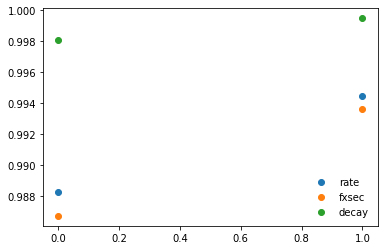

In [139]:
import matplotlib.pyplot as plt

ratios_rate = []
ratios_fxsec = []
ratios_decay = []
for pair in df:
    ratios_rate.append(np.sum(pair[0]['w_event_rate'])/np.sum(pair[1]['w_event_rate']))
    ratios_fxsec.append(np.sum(pair[0]['w_flux_avg_xsec'])/np.sum(pair[1]['w_flux_avg_xsec']))
    
    ratios_decay.append(np.sum(pair[0]['w_decay_rate_0'])/np.sum(pair[1]['w_decay_rate_0']))

plt.scatter(range(2),ratios_rate, label="rate")
plt.scatter(range(2),ratios_fxsec, label="fxsec")
plt.scatter(range(2),ratios_decay, label="decay")
plt.legend(frameon=False)

# plt.scatter(range(0,2),case1, c='blue')
# plt.scatter(range(0,2),case2, c='orange')

(1, 10000000.0)

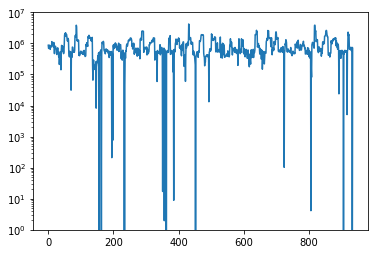

In [140]:

plt.plot(df_1['w_flux_avg_xsec'])
plt.yscale("log")
plt.ylim(1,1e7)


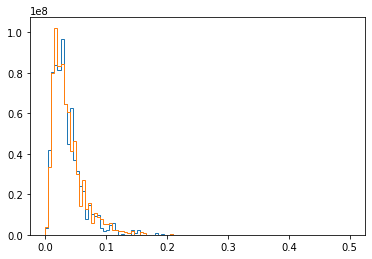

In [141]:
df1,df2 = df[0]
p1 = (df1['P_projectile'] - df1['P_decay_N_parent']).to_numpy()
h1 = dn.Cfourvec.dot4(p1,p1)

p2 = (df2['P_projectile'] - df2['P_decay_N_parent']).to_numpy()
h2 = dn.Cfourvec.dot4(p2,p2)

_ = plt.hist(np.sqrt(-h1), bins=100, range=(0,0.5), histtype='step', weights=df1['w_event_rate'], lw=1)
_ = plt.hist(np.sqrt(-h2), bins=100, range=(0,0.5), histtype='step', weights=df2['w_event_rate'], lw=1)


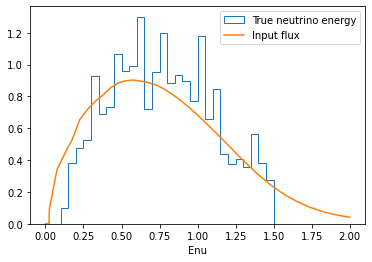

In [142]:
p1 = (df_2['P_projectile']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']).to_numpy()
# p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']+df_1['P_decay_N_daughter']).to_numpy()
h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,1.5), weights=df_2['w_flux_avg_xsec'],density=True, label='True neutrino energy')
plt.xlabel("Enu")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

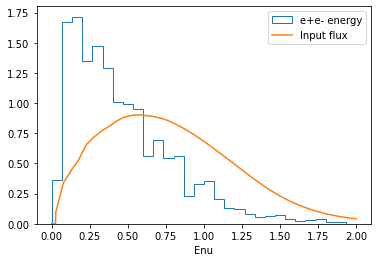

In [147]:

p1 = (df_1['P_decay_ell_minus']+df_1['P_decay_ell_plus']).to_numpy()

h1 = p1[:,0]
_ = plt.hist(h1, bins=30, histtype='step', range=(0,2), weights=df_1['w_event_rate'],density=True, label='e+e- energy')
plt.xlabel("Enu")
# plt.yscale("log")


x = np.linspace(0,2, 1000)
y = df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)/( df_1.attrs['experiment'].FLUX_FUNCTIONS[1](x)*(x[1]-x[0])).sum()

plt.plot(x,y, label='Input flux')
plt.legend()

Text(0.5, 0, 'Enu')

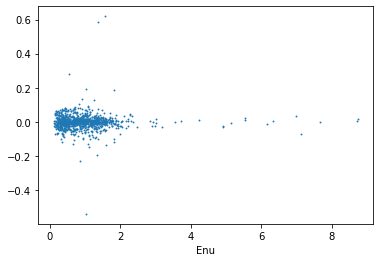

In [129]:
p1 = (df_1['P_projectile']).to_numpy()
x = p1[:,0]
y  = (df_1['P_decay_N_parent']).to_numpy()[:,2]
_ = plt.scatter(x, y, marker='.', s=3,  label='True neutrino energy')
plt.xlabel("Enu")
